<font size="7">**NEW blob DE analysis**</font>

<font size="4">This notebook demonstrates how to use esmeralda output for blob cut analysis for double escape peak. It can be adapted to different classifiers by adding classifier prediction to corresponding dataframe. 
1. First the events within fiducial volume and with one track are selected
2. The unbinned fit is used to estimate initial number of signal and background events
3. Moving the blob threshold the sensitivities and fom are calculated
    
**Note that the z-width and callibration is not included in this notebook!!**

In [17]:
%%capture
! wget https://www.dropbox.com/s/q2tp8gfrfen49nj/cdst_6485.h5

In [18]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd
import scipy.integrate as integrate

import matplotlib as mpl
#import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import iminuit, probfit
import scipy.stats as stat
from scipy.special import factorial as fact

import invisible_cities.core.fit_functions     as fitf
from   invisible_cities.core.stat_functions    import poisson_sigma

import invisible_cities.reco.dst_functions     as dstf

from   invisible_cities.icaro.hst_functions import hist
from   invisible_cities.icaro.hst_functions import gausstext
from   invisible_cities.icaro.hst_functions import labels

from invisible_cities.io.dst_io import load_dsts, load_dst

In [19]:
tracks_df  = load_dst('cdst_6485.h5', 'Tracking', 'Tracks')
summary_df = load_dst('cdst_6485.h5', 'Summary', 'Events')

In [20]:
tracks_ev_df = tracks_df.merge(summary_df, on='event', how='left')

In [21]:
#selection
R_max = 178
finite_en_mask   =  ~summary_df.evt_out_of_map
fid_cut_mask     = summary_df.evt_r_max<R_max
one_track_mask   = summary_df.evt_ntrks==1
events_pass_cuts = summary_df[fid_cut_mask & one_track_mask].event

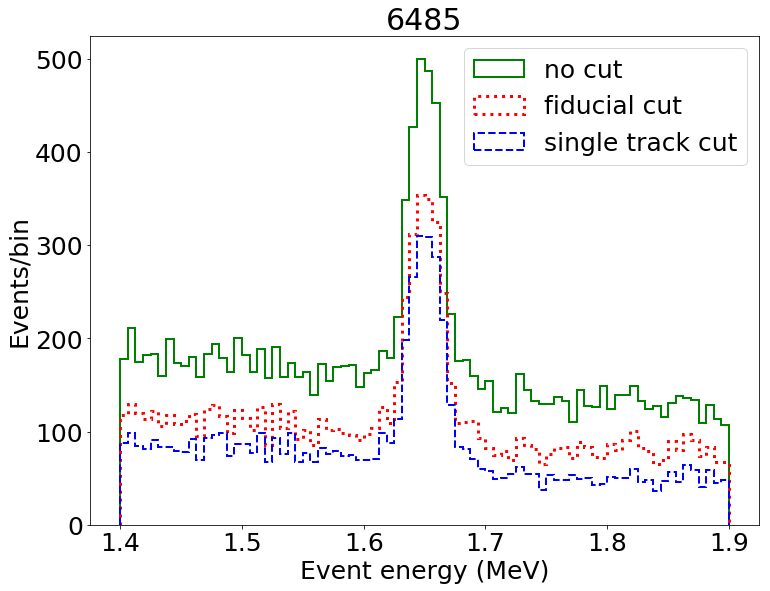

In [22]:
fig = plt.figure()
fig.set_figwidth(12.0)
fig.set_figheight(9.0)

plt.rcParams.update({'font.size': 25})
bins = 80
plot_range = (1.4, 1.9)
plt.hist(summary_df[finite_en_mask].evt_energy, label='no cut', range=plot_range,  color='green',
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=2.0);
plt.hist(summary_df[fid_cut_mask].evt_energy, label='fiducial cut', range=plot_range, color='red',
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=3.0, linestyle=':');
plt.hist(summary_df[one_track_mask & fid_cut_mask].evt_energy, label='single track cut', range=plot_range, color='blue',
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=2.0, linestyle='--');
lnd = plt.legend(loc=1)
labels('Event energy (MeV)', 'Events/bin', '6485')

## select track_df with one track only , fiducial cut and not overlapping blob energy; and make energy_cut mask - events of energies inside the range

In [23]:
fit_range = plot_range
tracks_df_1trk = tracks_df[tracks_df.event.isin(events_pass_cuts) & (tracks_df.ovlp_blob_energy==0)]
energy_cut_mask = (tracks_df_1trk.energy<fit_range[1]) & (tracks_df_1trk.energy>fit_range[0])


## define fitting functions and functions to calculate efficiency and fom curve


In [24]:
def expo(x, tau):
        a0 = 1/(tau*(np.exp(-fit_range[0]/tau)-np.exp(-fit_range[1]/tau)))
        return a0*np.exp(-x/tau)
    
norm_expo = probfit.Extended(expo, extname='Nb')
gauss = probfit.Extended(probfit.rename(probfit.gaussian, ['x', 'mu', 'sigma']), extname='Ns')

# Define an extended PDF consisting of two components
pdf = probfit.AddPdf(norm_expo, gauss)

In [25]:
def find_numb_of_events_ml_unbinned_wide(fit_result, fit_range, exp, gauss, e_min, e_max):
    s_wide     = fit_result.values['Ns']
    err_s_wide = fit_result.errors['Ns']
    b_wide     = fit_result.values['Nb']
    err_b_wide = fit_result.errors['Nb']
    mu         = fit_result.values['mu']
    err_mu     = fit_result.errors['mu']
    sigma      = fit_result.values['sigma']
    err_sigma  = fit_result.errors['sigma']
    tau        = fit_result.values['tau']
    err_tau    = fit_result.errors['tau']
    cov_sb     = fit_result.covariance['Ns', 'Nb']
    
    cov_smu     = fit_result.covariance['Ns', 'mu']
    cov_ssigma  = fit_result.covariance['Ns', 'sigma']
    cov_musigma = fit_result.covariance['mu', 'sigma']
    covbtau     = fit_result.covariance['Nb', 'tau']

    integral_sig  = integrate.quad(gauss, e_min, e_max, args=(mu, sigma, s_wide))
    integral_bckg = integrate.quad(exp, e_min, e_max, args=(tau, b_wide))

    s = integral_sig[0]
    b = integral_bckg[0]
    tot = s+b
    
    def der_g_ns(x, mu, sigma, ns):
        return 1/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)
    def der_g_mu(x, mu, sigma, ns):
        return ns/(2*np.pi)**.5 * np.exp(-0.5*(x-mu)**2./sigma**2.) * (x-mu)/sigma**3
    def der_g_sigma(x, mu, sigma, ns):
        return ns * np.exp(-0.5*(x-mu)**2./sigma**2.)*(x-mu)**2/(2*np.pi)**.5/sigma**4 - \
               ns*np.exp(-0.5*(x-mu)**2./sigma**2.)/(2*np.pi)**.5/sigma**2

    der_i_ns    = integrate.quad(der_g_ns,    e_min, e_max, args=(mu, sigma, s_wide))
    der_i_mu    = integrate.quad(der_g_mu,    e_min, e_max, args=(mu, sigma, s_wide))
    der_i_sigma = integrate.quad(der_g_sigma, e_min, e_max, args=(mu, sigma, s_wide))
    
    var_s = (der_i_ns[0]*err_s_wide)**2 + (der_i_mu[0]*err_mu)**2 + (der_i_sigma[0]*err_sigma)**2 + \
             2*der_i_mu[0]*der_i_sigma[0]*cov_musigma + 2*der_i_mu[0]*der_i_ns[0]*cov_smu + 2*der_i_sigma[0]*der_i_ns[0]*cov_ssigma
    
    def der_e_nb(x, tau, nb):
        a0 = 1/(tau*(np.exp(-fit_range[0]/tau)-np.exp(-fit_range[1]/tau)))
        return a0*np.exp(-x/tau)
    def der_e_tau(x, tau, nb):
        den = np.exp(-fit_range[0]/tau) - np.exp(-fit_range[1]/tau)
        exp = np.exp(-x/tau)
        return b_wide*(-1/tau**2*exp/den  + \
                       1/tau*(x/tau**2*exp/den-exp/den**2/tau**2*(fit_range[0]*np.exp(-fit_range[0]/tau)- \
                                                                  fit_range[1]*np.exp(-fit_range[1]/tau))))
    
    der_i_nb = integrate.quad(der_e_nb, e_min, e_max, args=(tau, b_wide))
    der_i_tau = integrate.quad(der_e_tau, e_min, e_max, args=(tau, b_wide))
    
    var_b = (der_i_nb[0]*err_b_wide)**2 + (der_i_tau[0]*err_tau)**2 + 2*der_i_tau[0]*der_i_nb[0]*covbtau

    return (tot, s, b, np.sqrt(var_s), np.sqrt(var_b))

def sig_and_bckg_after_cut(df_tracks, threshold, pdf, e_min_one, e_max_one, pars):
    df_after_cut = df_tracks[df_tracks.eblob2.values > threshold]
    energy = df_after_cut.energy.values
    unbinned_likelihood = probfit.UnbinnedLH(pdf, energy, extended=True)
    #pars = dict(Ns=9000, Nb=10000, tau=700, mu=1592, sigma=5)
    minuit = iminuit.Minuit(unbinned_likelihood, pedantic=False, print_level=0, **pars)
    minuit.migrad()
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    ax.set_xlabel('Track energy (keV)')
    ax.set_ylabel('Events/bin')
    unbinned_likelihood.show(minuit, ax=ax, bins=80, parts=True);
    minuit.print_fmin()
    minuit.print_matrix()

    n_tot_after, s_after, b_after, err_s, err_b = find_numb_of_events_ml_unbinned_wide(minuit, fit_range, norm_expo, \
                                                                                       gauss, e_min_one, e_max_one)
    print('Between {0} and {1}, number of signal = {2} +- {3}, background = {4} +- {5}'.format(e_min_one, e_max_one, \
                                                                                               s_after, err_s, \
                                                                                               b_after, err_b))
    
    return (n_tot_after, s_after, b_after, err_s, err_b)

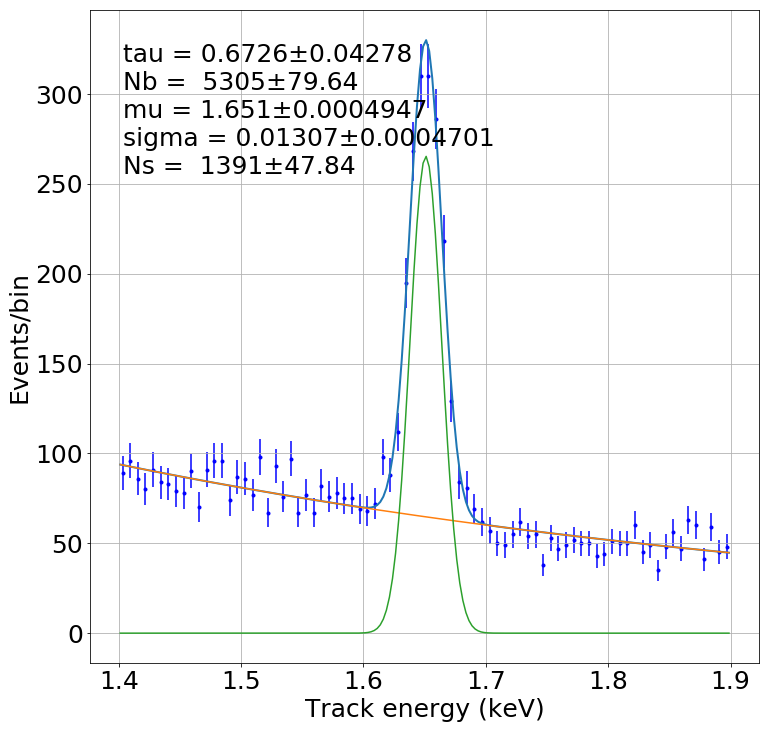

------------------------------------------------------------------
| FCN = -5.795E+04              |     Ncalls=181 (181 total)     |
| EDM = 2.3E-06 (Goal: 5E-06)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.016 -0.043 -0.064 -0.035 |
|    Nb 

In [26]:
#calculate initial number of signal and background
n_tot_0, n_sig_0, n_bckg_0, err_n_sig_0, err_n_bckg_0 = sig_and_bckg_after_cut(tracks_df_1trk[energy_cut_mask], 0, pdf, *fit_range, dict(Ns=900, Nb=1200, tau=0.3, mu=1.65, sigma=0.005))
fs0 = n_sig_0/n_tot_0
fb0 = n_bckg_0/n_tot_0
err_fs0 = err_n_sig_0/n_tot_0
err_fb0 = err_n_bckg_0/n_tot_0

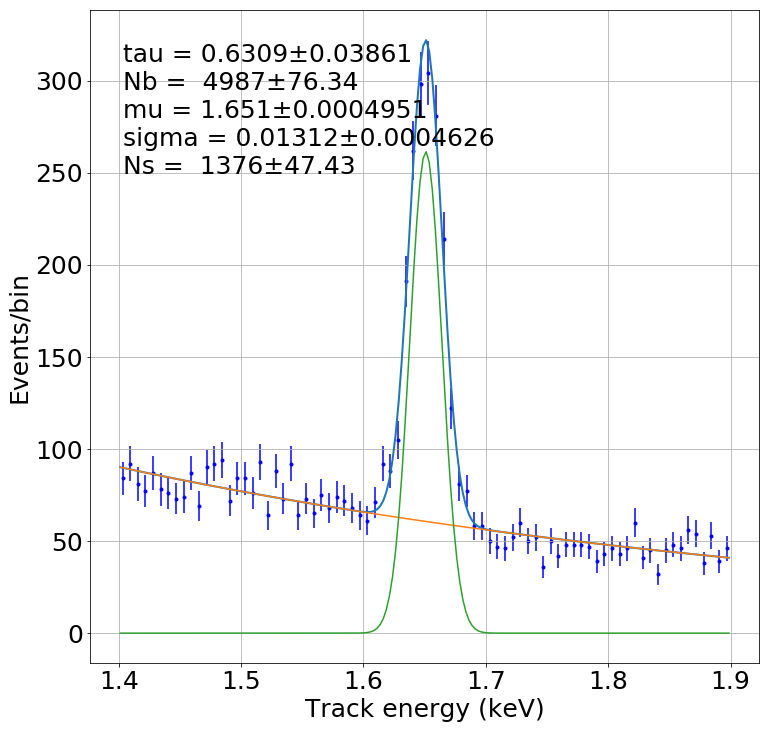

------------------------------------------------------------------
| FCN = -5.482E+04              |     Ncalls=165 (165 total)     |
| EDM = 1.05E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.050 -0.033 -0.030 -0.070 |
|    Nb 

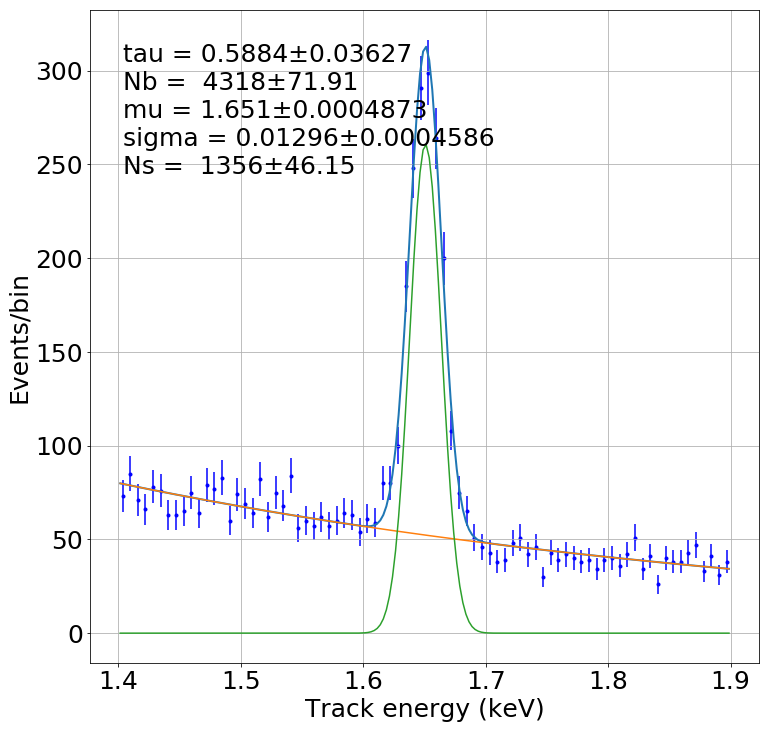

------------------------------------------------------------------
| FCN = -4.839E+04              |     Ncalls=162 (162 total)     |
| EDM = 4.05E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.040 -0.026 -0.053 -0.070 |
|    Nb 

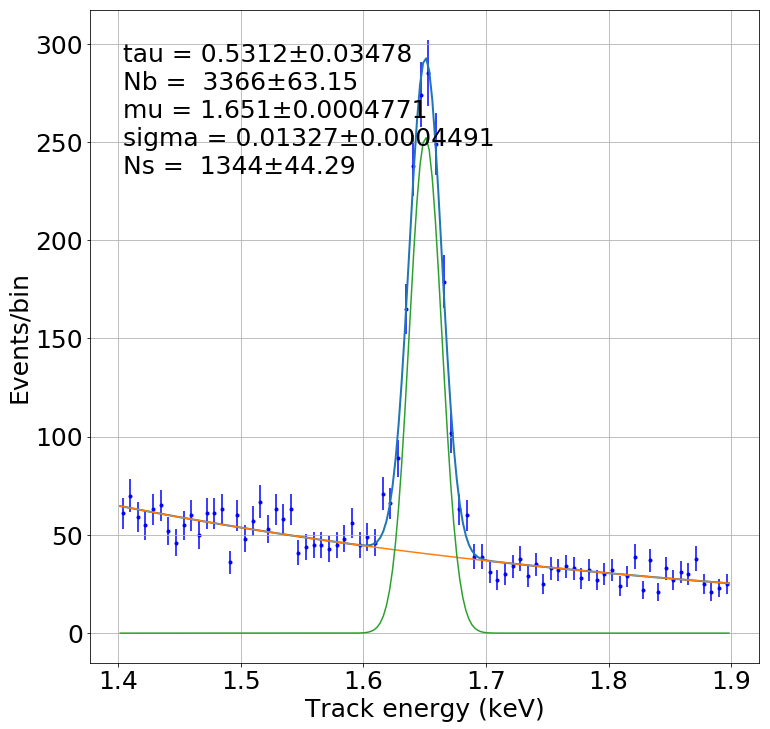

------------------------------------------------------------------
| FCN = -3.958E+04              |     Ncalls=198 (198 total)     |
| EDM = 1.02E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.045 -0.027 -0.058 -0.063 |
|    Nb 

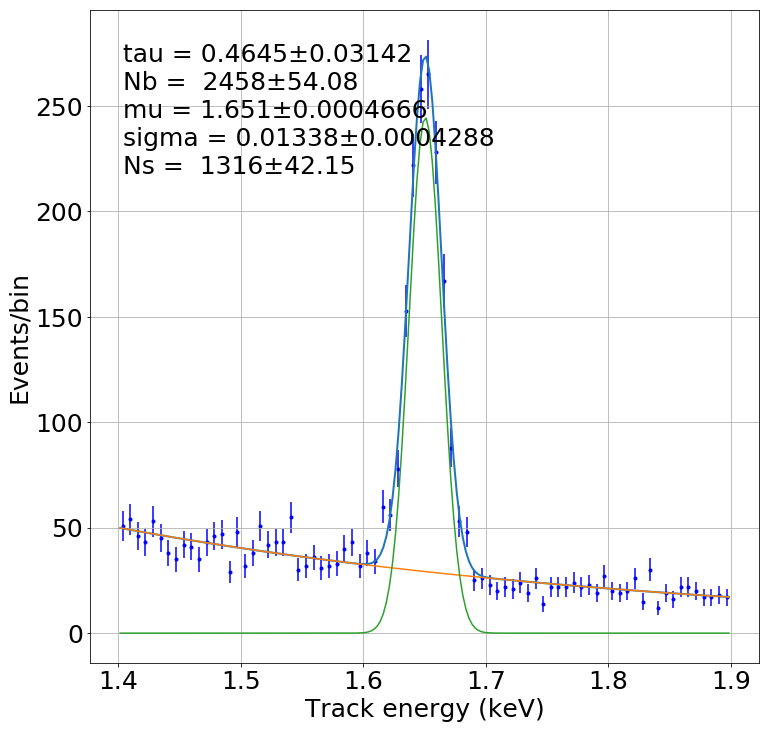

------------------------------------------------------------------
| FCN = -3.122E+04              |     Ncalls=187 (187 total)     |
| EDM = 2.45E-07 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.050 -0.024 -0.064 -0.065 |
|    Nb 

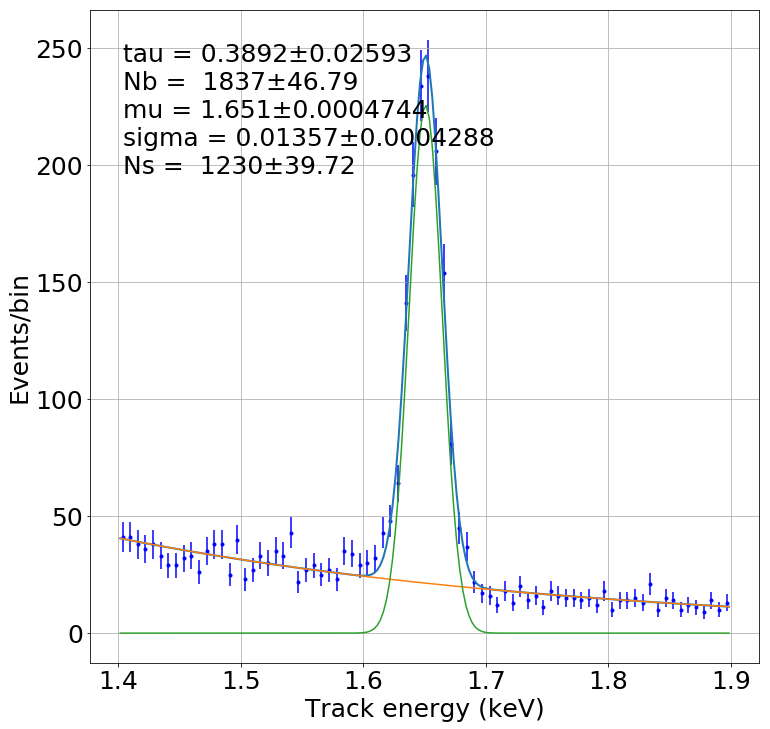

------------------------------------------------------------------
| FCN = -2.502E+04              |     Ncalls=173 (173 total)     |
| EDM = 1.99E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.060 -0.021 -0.075 -0.073 |
|    Nb 

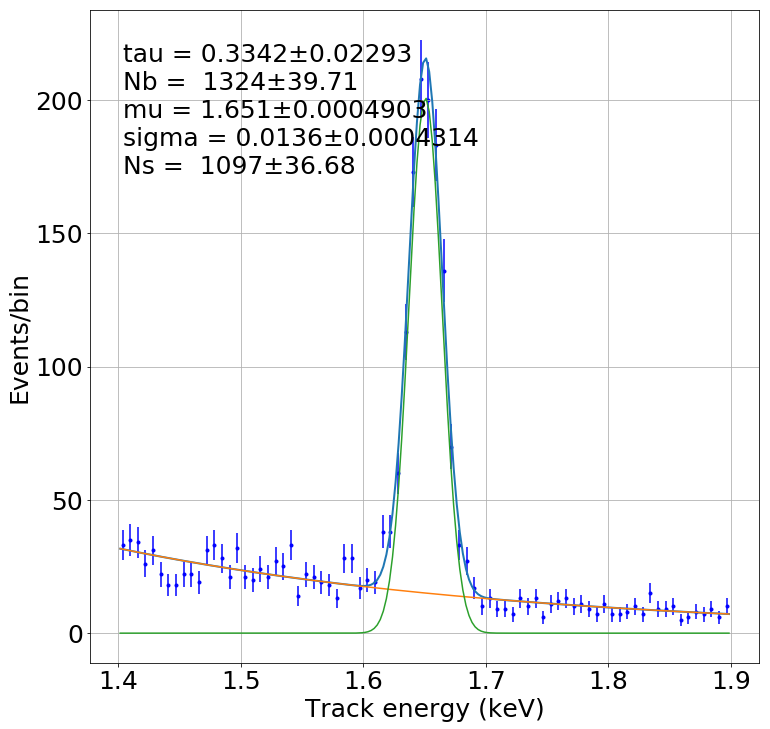

------------------------------------------------------------------
| FCN = -1.943E+04              |     Ncalls=173 (173 total)     |
| EDM = 4.32E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.069 -0.017 -0.083 -0.077 |
|    Nb 

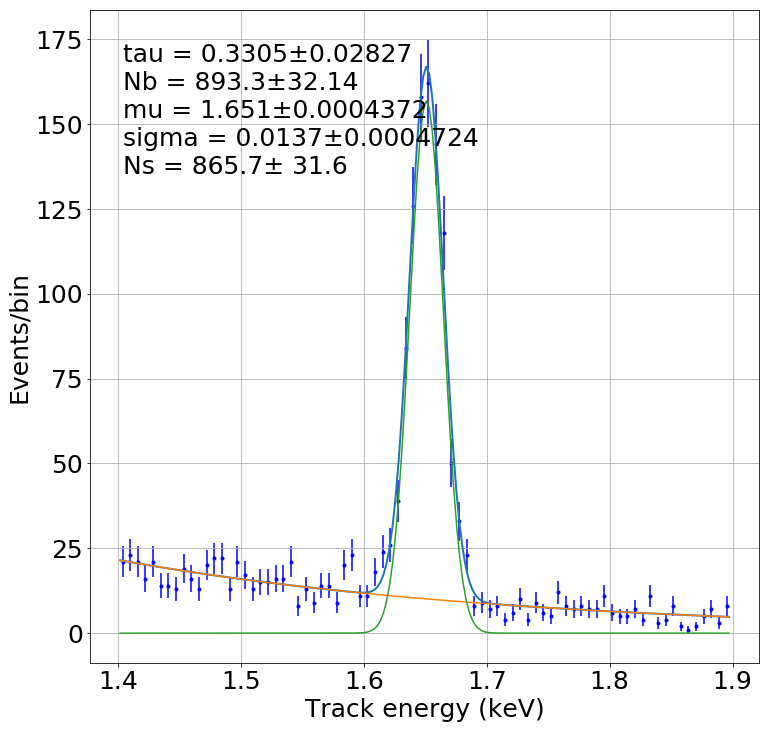

------------------------------------------------------------------
| FCN = -1.367E+04              |     Ncalls=139 (139 total)     |
| EDM = 3.3E-05 (Goal: 5E-06)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.091  0.014 -0.071 -0.084 |
|    Nb 

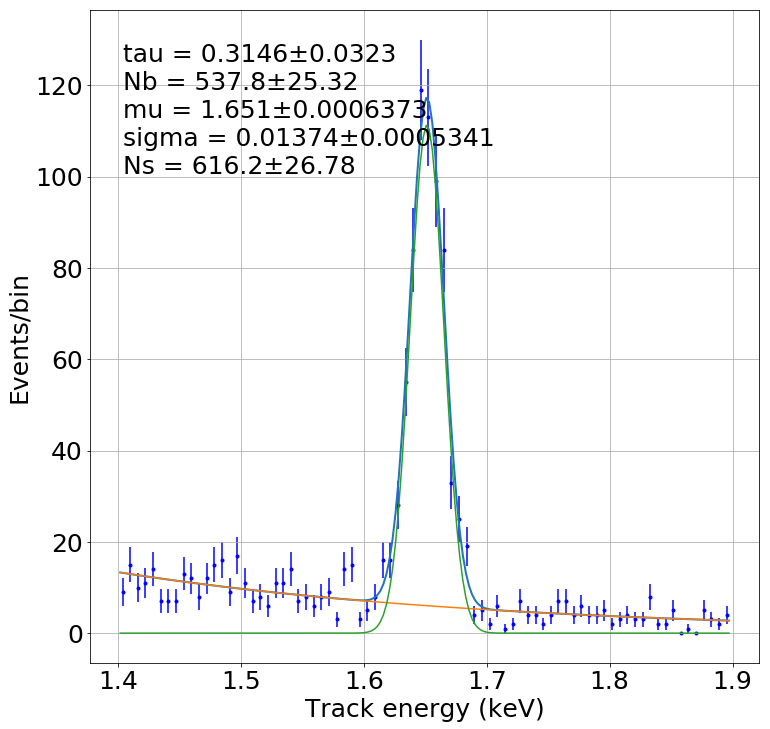

------------------------------------------------------------------
| FCN = -8584                   |     Ncalls=196 (196 total)     |
| EDM = 1.07E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.078 -0.019 -0.084 -0.073 |
|    Nb 

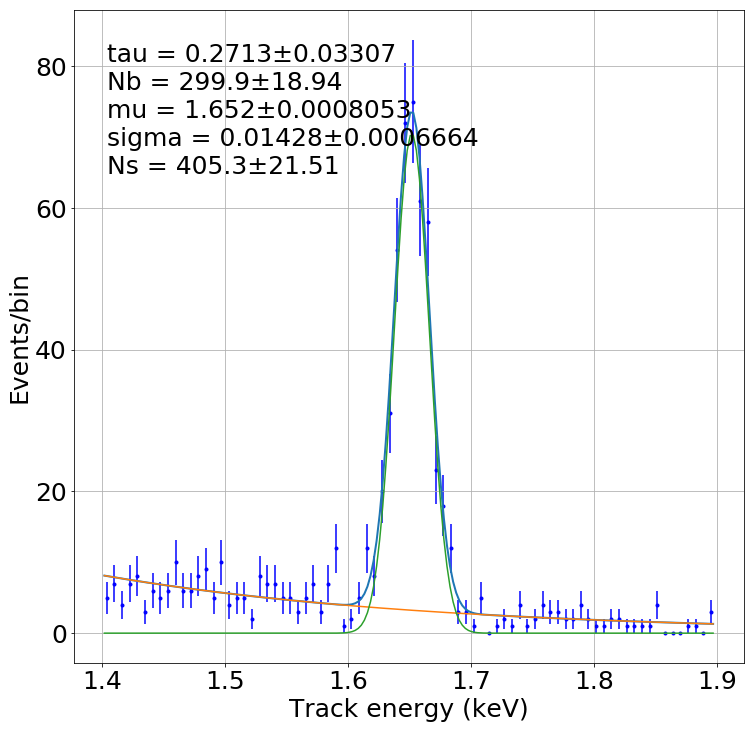

------------------------------------------------------------------
| FCN = -4954                   |     Ncalls=249 (249 total)     |
| EDM = 1.79E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.091 -0.012 -0.093 -0.080 |
|    Nb 

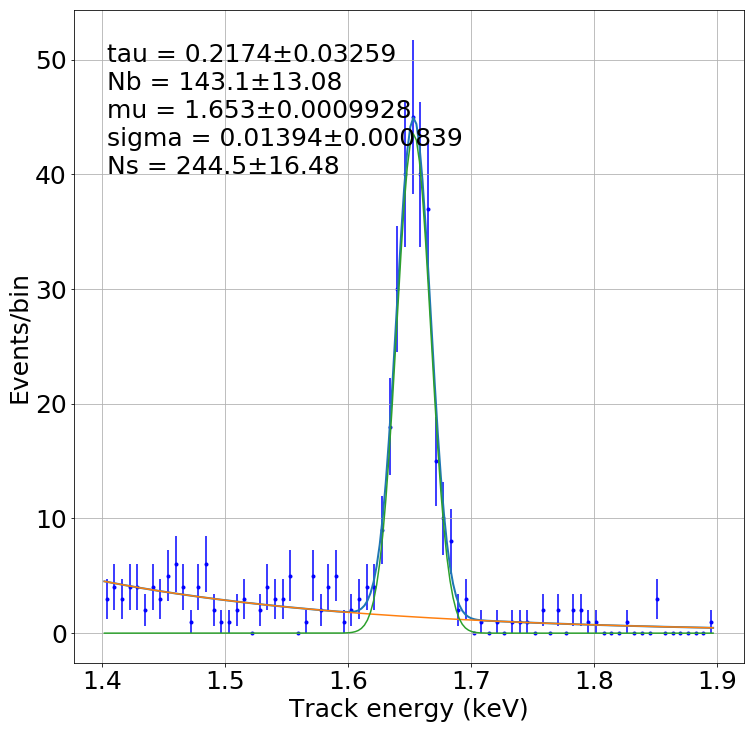

------------------------------------------------------------------
| FCN = -2550                   |     Ncalls=287 (287 total)     |
| EDM = 3.56E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------
|       |    tau     Nb     mu  sigma     Ns |
----------------------------------------------
|   tau |  1.000  0.115 -0.013 -0.129 -0.092 |
|    Nb 

In [27]:
#loop over different eblob2 cuts and calculate efficiencies and form

sig_eff_one = [1]
bckg_rej_one = [0]
fom_one = [1]
err_sig_one = [0]
err_bckg_one = [0]
err_fom_one = [0]

fs = [fs0]
fb = [fb0]
thresholds = np.linspace(0.1, 0.4, 10)
for th in thresholds:
    n_tot_after, n_sig_after, n_bckg_after, err_n_sig_after, err_n_bckg_after = sig_and_bckg_after_cut(tracks_df_1trk[energy_cut_mask], th, pdf, *fit_range,
                                                                                                      dict(Ns=900, Nb=1200, tau=0.3, mu=1.65, sigma=0.005))
    sig_eff  = n_sig_after/n_sig_0
    bckg_eff = n_bckg_after/n_bckg_0
    
    err_sig  = np.sqrt((err_n_sig_after/n_sig_0)**2 + (n_sig_after/n_sig_0**2*err_n_sig_0)**2)
    err_bckg = np.sqrt((err_n_bckg_after/n_bckg_0)**2 + (n_bckg_after/n_bckg_0**2*err_n_bckg_0)**2)
    err_fom  = np.sqrt(err_sig**2/bckg_eff + err_bckg**2*sig_eff**2/(4*bckg_eff**3))

    print('For threshold {0} keV, signal efficiency = {1}, background acceptance = {2}'.format(th, sig_eff, bckg_eff))

    sig_eff_one.append(sig_eff)
    bckg_rej_one.append(1 - bckg_eff)
    fom_one.append(sig_eff/np.sqrt(bckg_eff))

    err_sig_one.append(err_sig)
    err_bckg_one.append(err_bckg)
    err_fom_one.append(err_fom)
    
    fs.append(n_sig_after/n_tot_after)
    fb.append(n_bckg_after/n_tot_after)

In [28]:
ms = 7
lw = 2
ecolor='black'
capsize=3

r, g, b = (35, 180, 203)
data_color = (r / 255., g / 255., b / 255.)

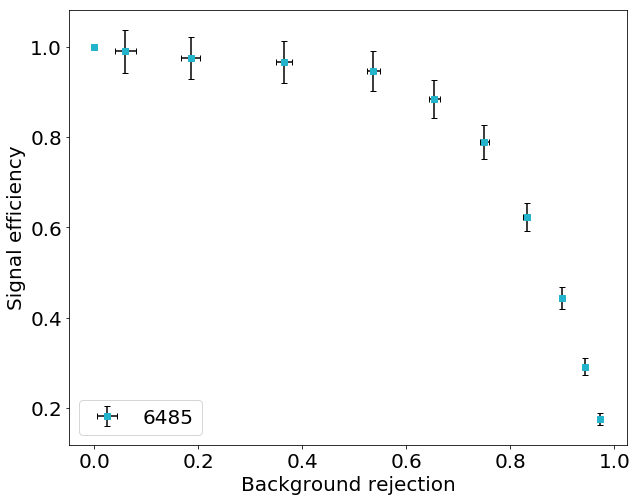

In [29]:
fig = plt.figure(1);
fig.set_figwidth(10.);
fig.set_figheight(8.);

plt.rcParams["font.size"] = 20

plt.errorbar(bckg_rej_one, sig_eff_one, xerr=err_bckg_one, yerr=err_sig_one, fmt='s', ecolor='black', \
             color=data_color, marker='s', capsize=3, label='6485')

plt.xlabel('Background rejection')
plt.ylabel('Signal efficiency')
lnd = plt.legend(loc=3)

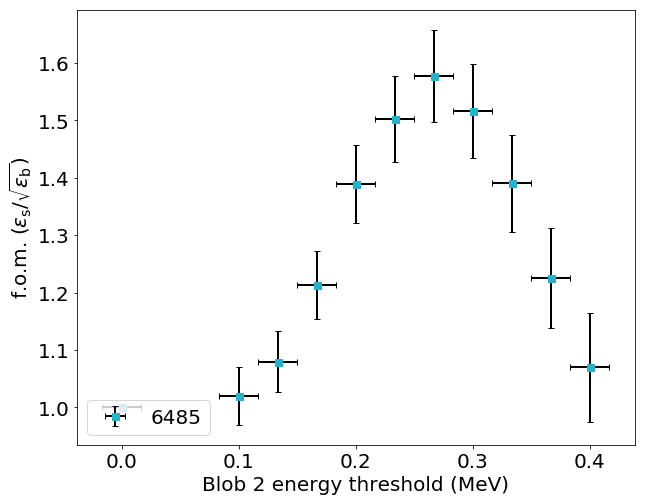

In [30]:
fig = plt.figure(1);
fig.set_figwidth(10.);
fig.set_figheight(8.);

x = np.append([0],thresholds)
bin_x=x[-1]-x[-2]
err_x = np.ones_like(x)*bin_x/2

plt.errorbar(x, fom_one, xerr=err_x[0], yerr=err_fom_one, fmt='s', markersize=ms, linewidth=lw, \
             color=data_color, ecolor=ecolor, capsize=capsize, label='6485')
plt.xlabel('Blob 2 energy threshold (MeV)')
plt.ylabel(r'f.o.m. ($\varepsilon_{\rm s}/\sqrt{\varepsilon_{\rm b}}$)')
lnd = plt.legend(loc=3)